In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
pd.options.display.max_columns = 9999

In [2]:
# Loading cvs files into dataframes 
df_pc = pd.read_csv("park_coordinates.csv")
df_weather = pd.read_csv("his_weather_final.csv", low_memory=False)
df_ozone = pd.read_csv("ozone.csv", index_col=0)

# Cross Joining the park coordinates data and the weather data 
def cartesian_product_basic(left, right):
    return (df_weather.assign(key=1).merge(df_pc.assign(key=1), on='key').drop('key', 1))
df_merged = cartesian_product_basic(df_weather, df_pc)

df_merged

,Address,Date time,Minimum Temperature,Maximum Temperature,Temperature,Dew Point,Relative Humidity,Heat Index,Wind Speed,Wind Gust,Wind Direction,Wind Chill,Precipitation,Precipitation Cover,Snow Depth,Visibility,Cloud Cover,Sea Level Pressure,Weather Type,Latitude_x,Longitude_x,Resolved Address,Name,Info,Latitude_y,Longitude_y,Park
0,"alamogordo,New Mexico",01/01/2015,21.1,43.4,32.1,19.7,60.46,NaN,9.6,NaN,234.58,13.6,0.0,12.5,NaN,10.0,73.2,1016.5,"Heavy Snow, Lightning Without Thunder, Fog",32.89925,-105.96032,"Alamogordo, NM, United States",NaN,NaN,44.338556,-68.273335,Acadia National Park
1,"alamogordo,New Mexico",01/01/2015,21.1,43.4,32.1,19.7,60.46,NaN,9.6,NaN,234.58,13.6,0.0,12.5,NaN,10.0,73.2,1016.5,"Heavy Snow, Lightning Without Thunder, Fog",32.89925,-105.96032,"Alamogordo, NM, United States",NaN,NaN,-14.258333,-170.683333,National Park of American Samoa
2,"alamogordo,New Mexico",01/01/2015,21.1,43.4,32.1,19.7,60.46,NaN,9.6,NaN,234.58,13.6,0.0,12.5,NaN,10.0,73.2,1016.5,"Heavy Snow, Lightning Without Thunder, Fog",32.89925,-105.96032,"Alamogordo, NM, United States",NaN,NaN,38.733081,-109.592514,Arches National Park
3,"alamogordo,New Mexico",01/01/2015,21.1,43.4,32.1,19.7,60.46,NaN,9.6,NaN,234.58,13.6,0.0,12.5,NaN,10.0,73.2,1016.5,"Heavy Snow, Lightning Without Thunder, Fog",32.89925,-105.96032,"Alamogordo, NM, United States",NaN,NaN,43.855380,-102.339691,Badlands National Park
4,"alamogordo,New Mexico",01/01/2015,21.1,43.4,32.1,19.7,60.46,NaN,9.6,NaN,234.58,13.6,0.0,12.5,NaN,10.0,73.2,1016.5,"Heavy Snow, Lightning Without Thunder, Fog",32.89925,-105.96032,"Alamogordo, NM, United States",NaN,NaN,29.127487,-103.242538,Big Bend National Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6792715,"twentynine palms,California",12/31/2019,44.1,58.8,50.6,29.7,46.12,NaN,18.9,25.3,302.64,40.0,0.0,0.0,NaN,10.0,26.5,1020.0,NaN,34.13561,-116.05461,"Twentynine Palms, CA, United States",NaN,NaN,43.604581,-103.421343,Wind Cave National Park
6792716,"twentynine palms,California",12/31/2019,44.1,58.8,50.6,29.7,46.12,NaN,18.9,25.3,302.64,40.0,0.0,0.0,NaN,10.0,26.5,1020.0,NaN,34.13561,-116.05461,"Twentynine Palms, CA, United States",NaN,NaN,61.710445,-142.985680,Wrangell-St. Elias National Park & Preserve
6792717,"twentynine palms,California",12/31/2019,44.1,58.8,50.6,29.7,46.12,NaN,18.9,25.3,302.64,40.0,0.0,0.0,NaN,10.0,26.5,1020.0,NaN,34.13561,-116.05461,"Twentynine Palms, CA, United States",NaN,NaN,44.427963,-110.588455,Yellowstone National Park
6792718,"twentynine palms,California",12/31/2019,44.1,58.8,50.6,29.7,46.12,NaN,18.9,25.3,302.64,40.0,0.0,0.0,NaN,10.0,26.5,1020.0,NaN,34.13561,-116.05461,"Twentynine Palms, CA, United States",NaN,NaN,37.865101,-119.538329,Yosemite National Park


In [3]:
# Susbsetting the dataframe leaving only the datapoints wihthin 30 miles of each park 
df_within_parks = df_merged[
    ((abs(df_merged["Latitude_x"] - df_merged["Latitude_y"])) <= 0.44) &\
    ((abs(df_merged["Longitude_x"] - df_merged["Longitude_y"])) <= 0.44)]

# Cleaning data 
df_vis_cloud = df_within_parks.loc[:, ["Park", "Date time", "Visibility", "Cloud Cover"]]
df_vis_cloud.loc[:, "Date time"] = pd.to_datetime(df_vis_cloud["Date time"], yearfirst=True)
df_vis_cloud = df_vis_cloud.rename(columns = {"Date time": "Year"})


In [4]:
# Calculating the average visibility/cloudiness by park by year 
df_visibility = df_vis_cloud.groupby(["Park", df_vis_cloud["Year"].dt.year])["Visibility"].mean().to_frame().reset_index()
df_cloudiness = df_vis_cloud.groupby(["Park", df_vis_cloud["Year"].dt.year])["Cloud Cover"].mean().to_frame().reset_index()   

In [5]:
# Merging visibility, cloudiness, and ozone dataframes 
df_merge1 = pd.merge(df_visibility, df_cloudiness)
df = pd.merge(df_merge1, df_ozone)
df

,Park,Year,Visibility,Cloud Cover,Ozone
0,Acadia National Park,2015,8.808219,44.377808,0.039481
1,Acadia National Park,2016,9.075956,41.175683,0.037727
2,Acadia National Park,2017,8.920822,43.106575,0.038381
3,Acadia National Park,2018,8.718630,29.928767,0.038959
4,Acadia National Park,2019,8.928177,4.335890,0.038305
...,...,...,...,...,...
132,Zion National Park,2015,9.868219,18.388356,0.051763
133,Zion National Park,2016,9.897541,16.325137,0.051678
134,Zion National Park,2017,9.898493,15.120411,0.046386
135,Zion National Park,2018,9.880000,15.379589,0.046870


In [6]:
# Ozone data by year
ozone_2015 = df.loc[df["Year"]==2015, "Ozone"]
ozone_2016 = df.loc[df["Year"]==2016, "Ozone"]
ozone_2017 = df.loc[df["Year"]==2017, "Ozone"]
ozone_2018 = df.loc[df["Year"]==2018, "Ozone"]
ozone_2019 = df.loc[df["Year"]==2019, "Ozone"]

# Visibility data by year
vis_2015 = df.loc[df["Year"]==2015, "Visibility"]
vis_2016 = df.loc[df["Year"]==2016, "Visibility"]
vis_2017 = df.loc[df["Year"]==2017, "Visibility"]
vis_2018 = df.loc[df["Year"]==2018, "Visibility"]
vis_2019 = df.loc[df["Year"]==2019, "Visibility"]

# Cloudiness data by year 
cloud_2015 = df.loc[df["Year"]==2015, "Cloud Cover"]
cloud_2016 = df.loc[df["Year"]==2016, "Cloud Cover"]
cloud_2017 = df.loc[df["Year"]==2017, "Cloud Cover"]
cloud_2018 = df.loc[df["Year"]==2018, "Cloud Cover"]
cloud_2019 = df.loc[df["Year"]==2019, "Cloud Cover"]

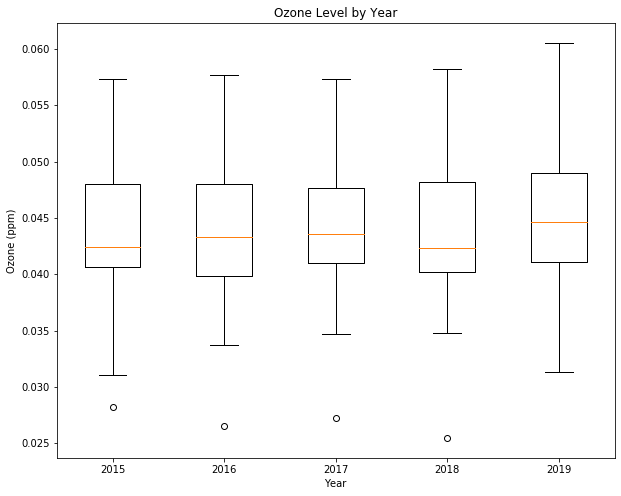

In [13]:
# Ozone Boxplot
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot([ozone_2015, ozone_2016, ozone_2017, ozone_2018, ozone_2019])
ax.set_xticklabels(["2015", "2016", "2017", "2018", "2019"])
ax.set_ylabel("Ozone (ppm)")
ax.set_xlabel("Year")
ax.set_title("Ozone Level by Year")
plt.savefig("ozone_by_year.png")

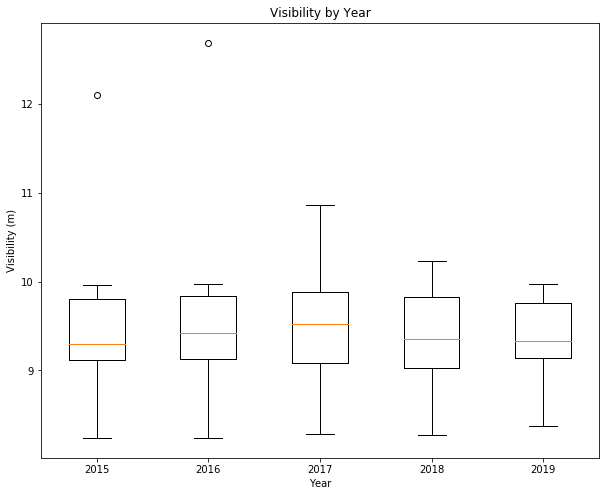

In [14]:
# Visibility Boxplot
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot([vis_2015, vis_2016, vis_2017, vis_2018, vis_2019])
ax.set_xticklabels(["2015", "2016", "2017", "2018", "2019"])
ax.set_ylabel("Visibility (m)")
ax.set_xlabel("Year")
ax.set_title("Visibility by Year")
plt.savefig("visibility_by_year.png")

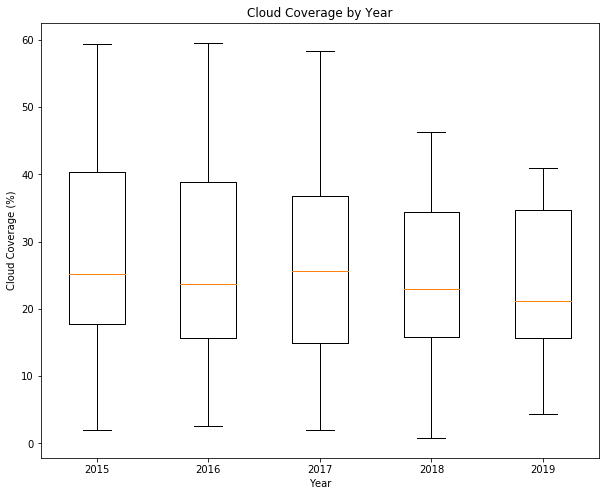

In [15]:
# Cloudiness Boxplot
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot([cloud_2015, cloud_2016, cloud_2017, cloud_2018, cloud_2019])
ax.set_xticklabels(["2015", "2016", "2017", "2018", "2019"])
ax.set_ylabel("Cloud Coverage (%)")
ax.set_xlabel("Year")
ax.set_title("Cloud Coverage by Year")
plt.savefig("cloudiness_by_year.png")

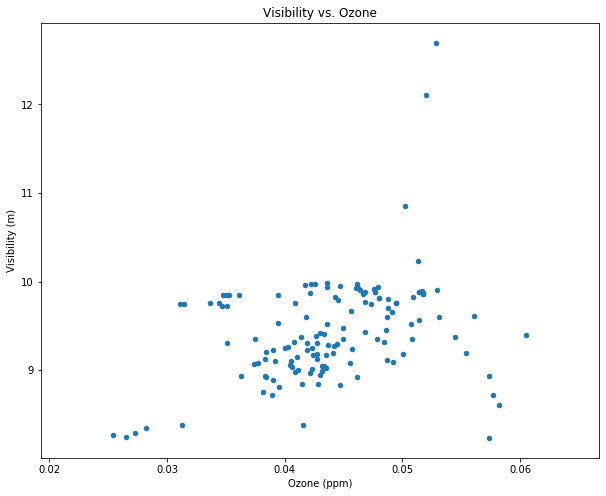

In [16]:
# Ozone vs. Visibility Plot
df.plot(kind="scatter", figsize=(10,8), x="Ozone", y="Visibility")
plt.title("Visibility vs. Ozone")
plt.xlabel("Ozone (ppm)")
plt.ylabel("Visibility (m)")
plt.savefig("ozone_vs_visibility.png")

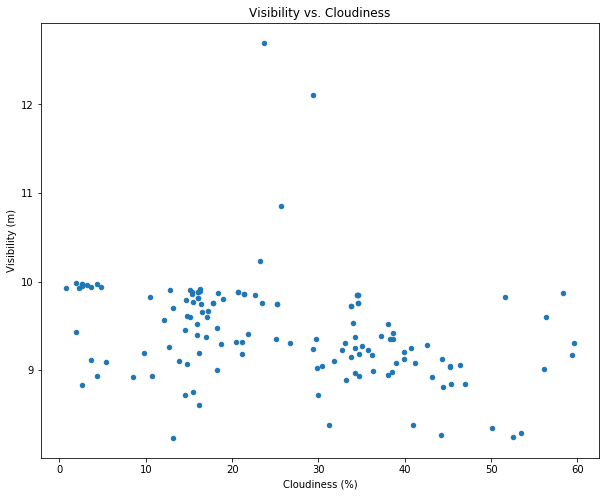

In [17]:
# Cloudiness vs. Visibility Plot

df.plot(kind="scatter", figsize=(10,8), x="Cloud Cover", y="Visibility")
plt.title("Visibility vs. Cloudiness")
plt.xlabel("Cloudiness (%)")
plt.ylabel("Visibility (m)")
plt.savefig("cloudiness_vs_visibility.png")

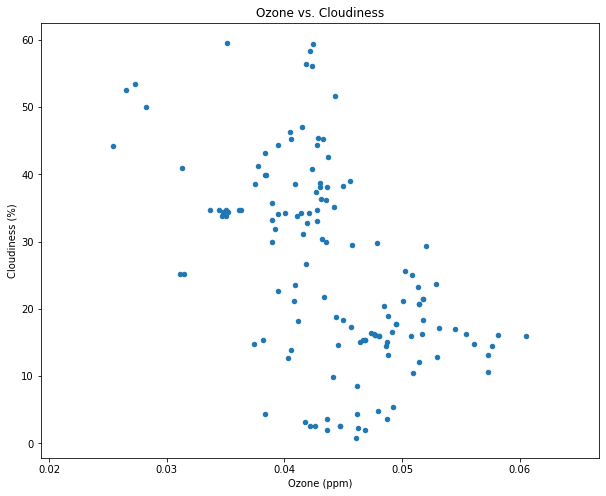

In [18]:
# Ozone vs. Cloud Coverage Plot
df.plot(kind="scatter", figsize=(10,8), x="Ozone", y="Cloud Cover")
plt.title("Ozone vs. Cloudiness")
plt.xlabel("Ozone (ppm)")
plt.ylabel("Cloudiness (%)")
plt.savefig("ozone_vs_cloudiness.png")